In [ ]:
!apt install xvfb

!pip install mpi4py
!pip install tensorflow==1.15.2
!pip install "gym==0.19.0"
!pip install pyvirtualdisplay
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!pip install stable_baselines
!pip install h5py

In [ ]:
'''
Imports
'''
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import gnwrapper

import gym
from gym.wrappers import Monitor

import tensorflow_hub as hub

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO1

from stable_baselines.gail import generate_expert_traj
from functools import partial
import h5py
import os

In [ ]:
'''
Create Env and Train Expert
'''
env = gym.make('CartPole-v1')

ppo1_expert = PPO1(MlpPolicy, env, verbose=0)
ppo1_expert.learn(total_timesteps=250000)
ppo1_expert.save("ppo1_cartpole")
ppo1_expert = PPO1.load("ppo1_cartpole")

In [ ]:
'''
Create Dataset Class for Generating + Storing Data
'''
class BCDataset(torch.utils.data.Dataset):
  def __init__(self, env, n_episodes, expert_policy):
    self.env = env
    self.n_episodes = n_episodes
    self.expert_policy = expert_policy
    self._generate()
    self._compute_stats()
  
  def _save(self, path):
    '''
    Save dataset to path as an hd5f file
    '''
    assert path[-4:] == 'hdf5'
    with h5py.File(path, 'w') as f:
      f['expert_obs'] = self.expert_obs.numpy()[:]
      f['expert_actions'] = self.expert_actions.numpy()[:]
  
  def _load(self, path):
    '''
    Load dataset from path
    '''
    assert os.path.exists(path)
    assert path[-4:] == 'hdf5'
    with h5py.File(path, 'r') as f:
      assert 'expert_obs' in f
      assert 'expert_actions' in f
      self.expert_obs = f['expert_obs'][:]
      self.expert_actions = f['expert_actions'][:]
    self._compute_stats()
  
  def _generate(self):
    '''
    Generate dataset by rolling out the expert policy in the input env for
    'n_episodes' total episodes
    '''
    self.expert_obs = []
    self.expert_actions = []
    for _ in range(self.n_episodes):
      obs = self.env.reset()
      while True:
        action, _ = self.expert_policy.predict(torch.as_tensor(obs))
        self.expert_obs += [obs[:]]
        self.expert_actions += [[action]]
        obs, rewards, done, info = env.step(action)
        if done: 
            break;
    self.expert_obs = torch.as_tensor(np.stack(self.expert_obs)).float()
    self.expert_actions = torch.as_tensor(np.stack(self.expert_actions)).float()
  
  def _compute_stats(self):
    '''
    Compute some basic stats that can use later on to normalize the training
    data / criterion function
    '''
    self.mean_expert_obs = torch.mean(self.expert_obs, axis=0)
    self.std_expert_obs = torch.std(self.expert_obs, axis=0)
    self.prop_pos_exmpls = torch.sum(self.expert_actions)/len(self)

  def __len__(self):
    '''
    Get total number of (obs, action) samples
    '''
    return self.expert_obs.shape[0]
  
  def __getitem__(self, i):
    '''
    Retrieve the ith (obs, action) sample
    '''
    return self.expert_obs[i], self.expert_actions[i]


def collate_fn(batch, obs_mean, obs_std):
  '''
  Simple collate function that reformates a list of (obs, action) tuples into
  stacked torch Tensors, with observations (which are input into the model
  during training) normalized via input (mean, std) torch vectors
  '''
  all_expert_obs = []
  all_expert_actions = []
  for item in batch:
    obs, actions = item
    all_expert_obs += [obs]
    all_expert_actions += [actions]
  return (torch.stack(all_expert_obs) - obs_mean)/obs_std, torch.stack(all_expert_actions)

In [ ]:
'''
Define BC Model as NN with a single hidden layer
'''
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Net, self).__init__()
        self.module = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
    	return self.module(x)

In [ ]:
'''
Configure the number of trajectory rollouts used to generate the training
and validation datasets, and initialize the corresponding dataset objects
'''
num_episodes = {'train': 10, 'validation': 5}
datasets = {phase: BCDataset(env, num_episodes[phase], ppo1_expert) for phase in ['train', 'validation']}

In [ ]:
'''
Set hyperparams
'''
pos_weight = (1 - datasets['train'].prop_pos_exmpls)/datasets['train'].prop_pos_exmpls # use the proportion of pos examples to compute a 'pos_weight' used to normalize binary cross entropy loss used to train the model
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # initialize the criterion function, Binary Cross Entropy Loss w/ Sigmoid
obs_dim = env.observation_space.shape[0] # unpack dimension of the observation space from the gym env
action_dim = env.action_space.shape # unpack dimension of the action space from the gym env
hidden_dim = 32 # set the hidden dimension of the model
learning_rate = 3e-4 # set the learning rate
batch_size = 64 # set the batch size
num_epochs = 50 # set the number of training/validation epochs

In [ ]:
'''
Train BC Model
'''
model = Net(obs_dim, action_dim, hidden_dim) # initialize the model
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # initialize the optimizer used for model trianing
custom_collate_fn = partial(collate_fn, # initialize the collate function via the train dataset stats
                     				obs_mean=datasets['train'].mean_expert_obs,
										 				obs_std=datasets['train'].std_expert_obs) 
dataloaders = {'train': torch.utils.data.DataLoader(datasets['train'], # initialize the train dataloader
                                             			batch_size=batch_size, 
																						 			shuffle=True, 
																						 			collate_fn=custom_collate_fn),
							'validation': torch.utils.data.DataLoader(datasets['validation'], # initialize the validation dataloader
                                             			batch_size=len(datasets['validation']), # Q: why do I set the batch size to the whole dataset here + omit shuffling?
																									collate_fn=custom_collate_fn)}
# Training/Validation Loop
for epoch in range(num_epochs+1):
	avg_accuracy = {}
	for phase in ['train', 'validation']:
		total_incorrect = 0
		for batch in iter(dataloaders[phase]):
			expert_obs, expert_actions = batch
			pred_actions = model(expert_obs)
			if phase == 'train':
				optimizer.zero_grad(set_to_none=True) # Q: why is it important to zero the optimizer gradients before computing the loss?
				loss = criterion(pred_actions, expert_actions)
				loss.backward()
				optimizer.step() # To do: look at the torch documention to make sure you understand what happens under the hood when you call 'step' on any optimizer
			else:
				with torch.no_grad(): # Q: why do we explicitly ~not~ track gradients during validation?
					loss = criterion(pred_actions, expert_actions)
		 	# Our version of cartpole features discrete policies, which output actions 0 or 1 at each timestep.
			# When training our BC model, however, we don't explicitly discretize the model outputs (Q: why?). 
			# To calculate the current model accuracy per batch, we do need to discretize the model outputs, 
			# casting any output action strictly greater than 0.5 to 1 and and less than or equal to 0.5 to 0.
			total_incorrect += torch.sum(torch.abs((torch.clip(pred_actions, 0, 1) + 0.5).int() - expert_actions))
	 	# Compute the average accuracy over each phase
		avg_accuracy[phase] = (len(datasets[phase]) - total_incorrect)/len(datasets[phase])
	# Print training/validation stats every 25 epochs
	if epoch % 25 == 0:
		print(f'epoch %i | avg train accuracy: %.2f%% | avg valid accuracy: %.2f%%' % (epoch, 
																																			np.array(avg_accuracy['train']).mean() * 100, 
																																			np.array(avg_accuracy['validation']).mean() * 100))


epoch 0 | avg train accuracy: 50.12% | avg valid accuracy: 50.36%
epoch 25 | avg train accuracy: 67.58% | avg valid accuracy: 66.32%
epoch 50 | avg train accuracy: 68.02% | avg valid accuracy: 66.88%


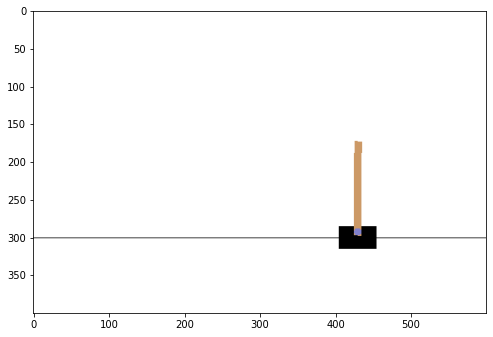

In [ ]:
'''
Render BC Agent and Generate Gifs
'''
env = gnwrapper.LoopAnimation(gym.make('CartPole-v1')) # Start Xvfb

obs = env.reset()

while True:
  env.render()
  # Q: why do we need to process the observations here when rollout out the model?
  processed_obs = (torch.as_tensor(obs) - datasets['train'].mean_expert_obs)/datasets['train'].std_expert_obs
  with torch.no_grad():
    processed_action = (model(processed_obs.float()) + 0.5).int().numpy()[0]
  obs, rewards, done, info = env.step(processed_action)
  if done: 
      break;

env.display()